# **Deep Convolution Generative Adversarial Network - DCGAN**

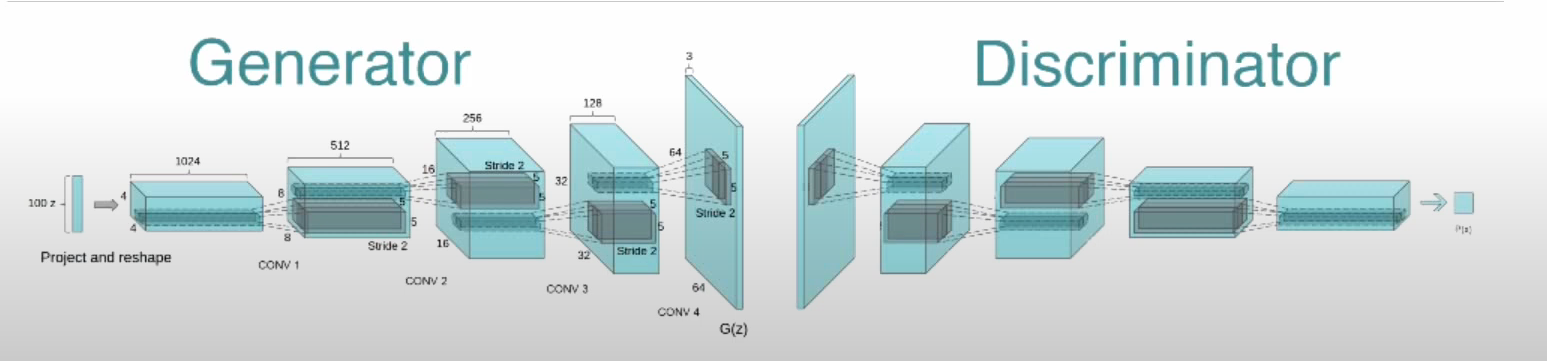


- It uses a standard CNN architecture on the discriminative model
- Convolutions are replaced with up-convolutions, so the representation at each layer of the generator is actually successively larger as it maps from a low dimensional latent vector onto a high-dimensional image
- coarse salient feature ⇒ dense & detailed Output
- Like other GAN’s DCGAN is also unstable, because of the architecture a slight change in the initial part of the training or in the structure of training can make our Generator produce noise
- Generator uses transpose Convolution,  to convert an n dimensional vector to fully fledged image.

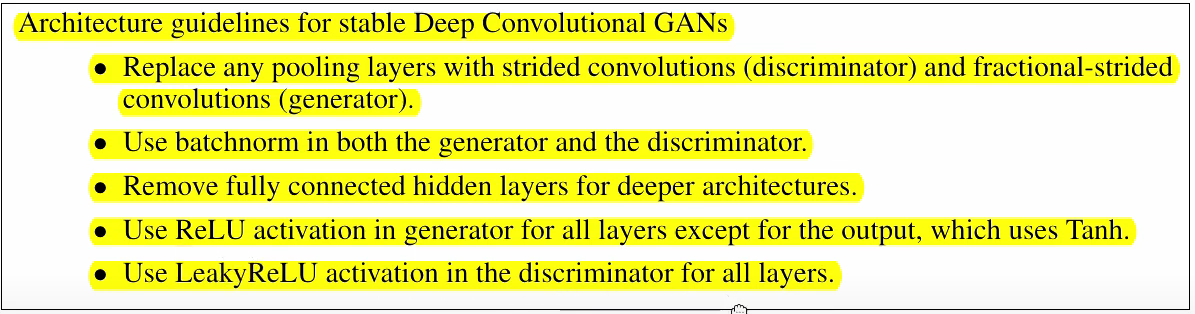

## PyTorch :)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import itertools
from glob import glob

## Utils 

In [2]:
def get_data_loader(path, batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])
    
    train_dataset = datasets.MNIST(
        root=path,
        train=True,
        transform=transform,
        download=True
    )
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )

    return train_loader

In [3]:
def plot_images(epoch, path, num_test_samples, generator, device):
    z = torch.randn(num_test_samples, 100, 1, 1, device=device)
    plot_grid_size = int(math.sqrt(num_test_samples))
    
    generated_fake_images = generator(z)
    path += "varable_noise/"
    title = "Variable Noise"
    fig, ax = plt.subplots(plot_grid_size, plot_grid_size, figsize=(6, 6))
    
    for i, j in itertools.product(range(plot_grid_size), range(plot_grid_size)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        
    for sample in range(num_test_samples):
        i = sample //plot_grid_size
        j = sample % plot_grid_size
        ax[i, j].cla()
        ax[i, j].imshow(
            generated_fake_images[sample].data.cpu().numpy().reshape(28, 28),
            cmap="Greys",
        )
    
    label = "Epoch_{}".format(epoch+1)
    fig.text(0.5, 0.05, label, ha="center")
    fig.suptitle(title)
    

## Generator

In [4]:
class Generator (nn.Module):
    """
    - noise_vector: Length of the Z input vector.
    - num_gen_filter: size of the geature maps that are propagated through the generator
    - num_ch: The number of channels in the output image (set to 1 for Gray scale image).
    Here, the height and width dimension of the images doest not change & only the channel dimension increases
    
    - in_channels: Number of channels/filters in the input image
    - out_channels: Number of channels/filters produced by the convolution
    
    """
    def __init__(self, num_ch:int, noise_vector, num_gen_filter:int):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            #Layer1
            nn.ConvTranspose2d(
                in_channels=noise_vector,
                out_channels=num_gen_filter * 4, # Hyper Paraneter
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False # BatchNorm2d includes bias... So in ConvT2d, bias=False 
            ),
            nn.BatchNorm2d(num_gen_filter * 4),
            nn.ReLU(True),
            
            #Layer-2
            nn.ConvTranspose2d(
                in_channels=num_gen_filter * 4,
                out_channels=num_gen_filter * 2, # Hyper Paraneter
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False # BatchNorm2d includes bias... So in ConvT2d, bias=False 
            ),
            nn.BatchNorm2d(num_gen_filter * 2),
            nn.ReLU(True),
            
            #Layer-3
            nn.ConvTranspose2d(
                in_channels=num_gen_filter * 2,
                out_channels=num_gen_filter, # Hyper Paraneter
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False # BatchNorm2d includes bias... So in ConvT2d, bias=False 
            ),
            nn.BatchNorm2d(num_gen_filter),
            nn.ReLU(True),
            
            #layer-4
            nn.ConvTranspose2d(
                in_channels=num_gen_filter,
                out_channels=num_ch , # Hyper Paraneter
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False # BatchNorm2d includes bias... So in ConvT2d, bias=False 
            ),

            #Output
            nn.Tanh()  
        )
    
    
    def forward(self, input):
        output = self.network(input)
        return output
        

## Descriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, num_ch, num_disc_filter):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            #Layer-1
            nn.Conv2d(
                in_channels=num_ch,
                out_channels=num_disc_filter,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, True), # first Input is the Hyper-Parameter
            
            #Layer-2
            nn.Conv2d(
                in_channels=num_disc_filter,
                out_channels=num_disc_filter * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(num_disc_filter*2),
            nn.LeakyReLU(0.2, True),
            
            #Layer-3
            nn.Conv2d(
                in_channels=num_disc_filter * 2,
                out_channels=num_disc_filter * 4,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(num_disc_filter*4),
            nn.LeakyReLU(0.2, True),
            
            #Layer-4
            nn.Conv2d(
                in_channels=num_disc_filter * 4,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            
            #Output
            nn.Sigmoid(),
        
        )
        
    #Handler of the Neural Network
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

## Train

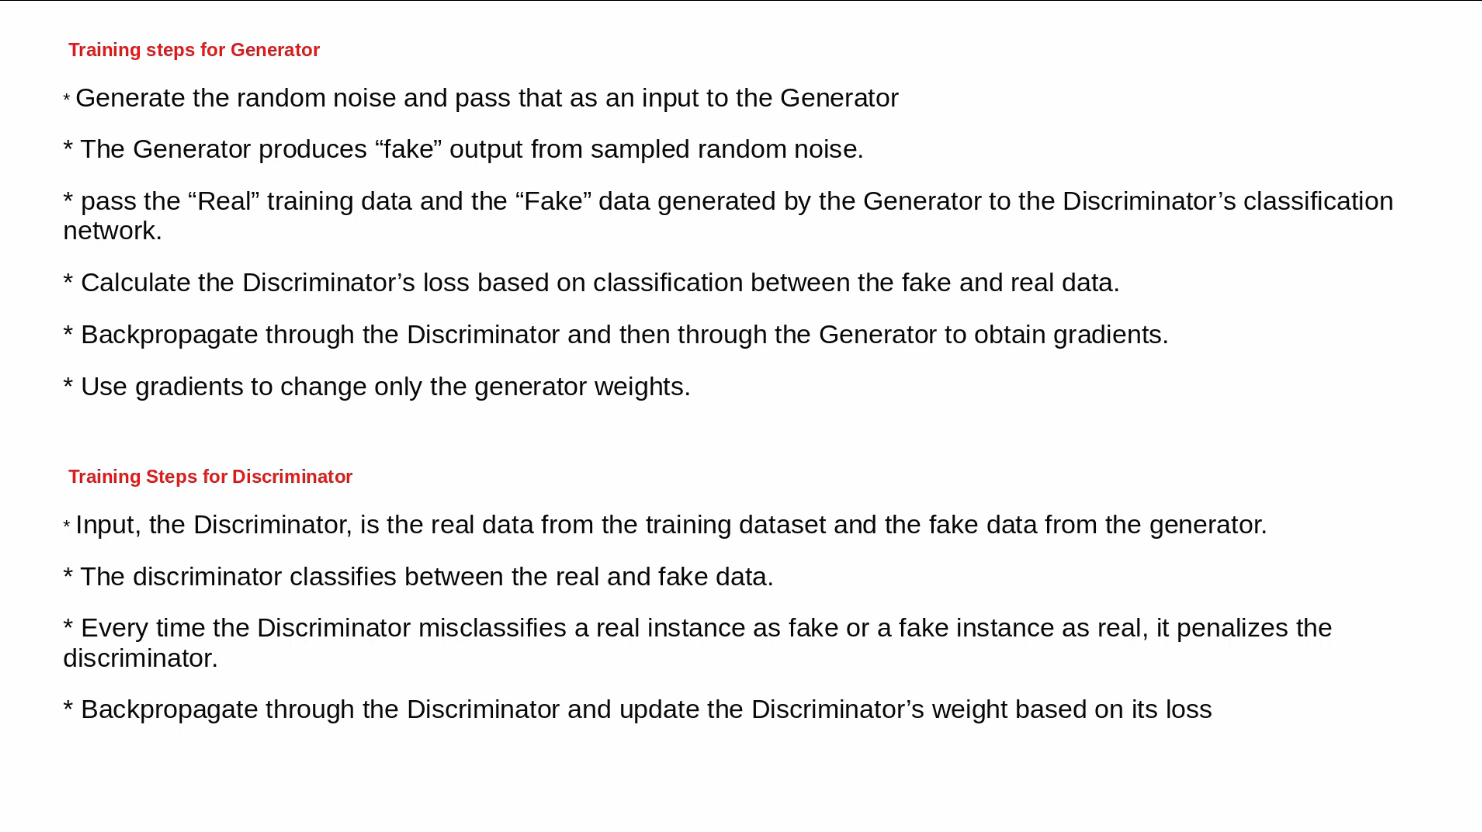

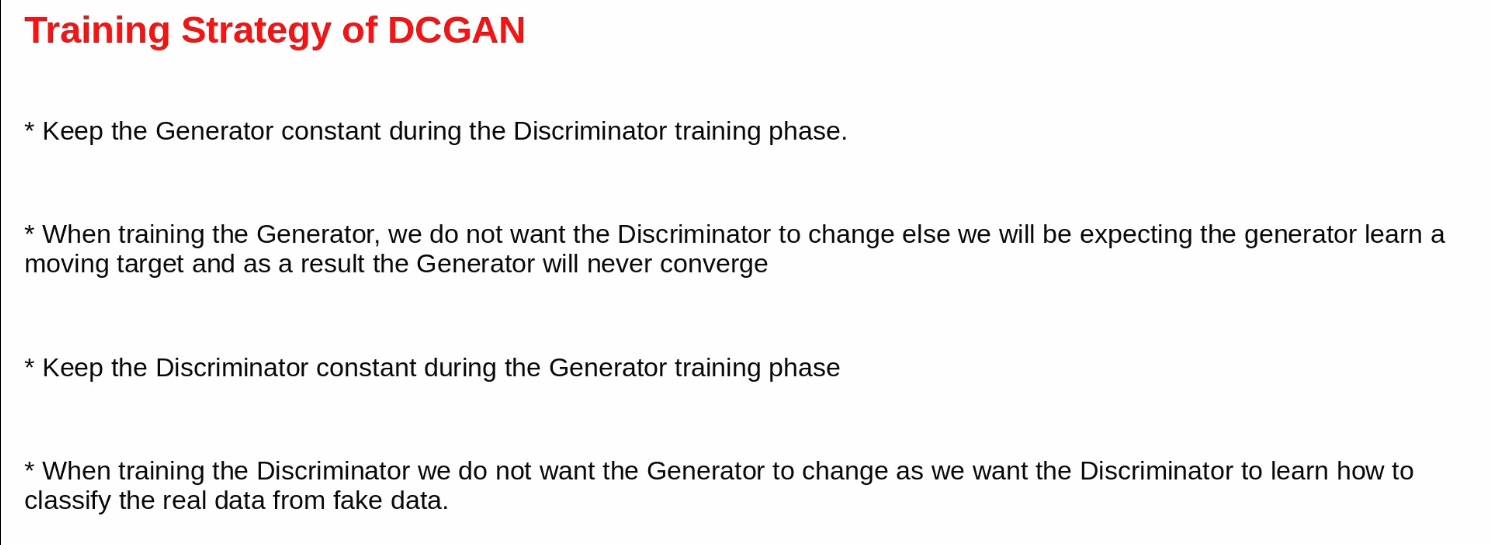

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
device

device(type='cuda')

- The standard process to train a DCGAN network is to first train the discriminator on the batch of samples. So after trained on real images, the discriminator will be able to separate the real and the fake images
- fake_labels => [0, 0, 0...]
- real_labels => [1, 1, 1...]

In [7]:
def train(num_epochs, discriminator_net, generator_net, optimizerD, optimizerG,
         train_loader, fake_label, real_label, criterion, output_path, 
         num_test_samples, device, noise_vector):
    
    num = len(train_loader)
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size_real_imgs = real_images.shape[0]
            '''
            Discriminator Network Training
            maximize [ log(D(x)) + log(1-D(G(z)))) ] x => Real Images
            '''
            #discriminator_net
            discriminator_net.zero_grad()
            real_images = real_images.to(device)
            
            #setting the output of discrimiator as all real images
            label = torch.full((batch_size_real_imgs, ), real_label, device=device)
            output = discriminator_net(real_images)
            
            #compute error based on the criterion
            loss_disc_real = criterion(output, label)
            
            #backwared_propogation
            loss_disc_real.backward()
            D_x = output.mean().item()
            
            #generator_net
            noise = torch.randn(batch_size_real_imgs, noise_vector, 1, 1, device=device)
            fake_images = generator_net(noise)
            
            #As now training on fake image, labels => 0
            label.fill_(fake_label)
            output = discriminator_net(fake_images.detach())
            
            loss_disc_fake = criterion(output, label)
            loss_disc_fake.backward()
            
            D_G_z1 = output.mean().item()
            
            loss_disc_total = loss_disc_real + loss_disc_fake
            optimizerD.step()
           
            """
            Generator Netowrk
            maximize log(D(G(z))) z => Feature Vector
            """
            generator_net.zero_grad()
            label.fill_(real_label)
            
            #fooling the discriminator_net
            output = discriminator_net(fake_images)
            
            #to extent the fake images as real we will find the loss and train the genrator layer
            loss_generator = criterion(output, label)
            loss_generator.backward()
            
            D_G_z2 = output.mean().item()
            optimizerG.step() #step() to update the weights
            
            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}".format(
                        epoch + 1,
                        num_epochs,
                        i + 1,
                        num_epochs // batch_size_real_imgs + 1,
                        loss_disc_total.item(),
                        loss_generator.item(),
                        D_x,
                        D_G_z1,
                        D_G_z2,
                    )
                )

In [8]:
path = "/home/mnk/MNK/Mega/AI/Deep-Learning/Generative-Adversarial-Network/MNIST/"

batch_size = 64
output_path = "/home/mnk/MNK/Mega/AI/Deep-Learning/Generative-Adversarial-Network/"
train_loader = get_data_loader(path, batch_size)
discriminator_net = Discriminator(num_ch=1, num_disc_filter=16).to(device)
generator_net = Generator(num_ch=1, noise_vector = 100, num_gen_filter=16).to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(discriminator_net.parameters(), lr=0.001)
optimizerG = optim.Adam(generator_net.parameters(), lr=0.001)

real_label = 1.0
fake_label = 0.0

num_test_samples = 16
fized_noise = torch.randn(num_test_samples, 100, 1, 1, device=device)
num_epochs = 10
noise_vector = 100

In [9]:
train_loader

In [10]:
criterion

BCELoss()

In [11]:
discriminator_net

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [12]:
generator_net

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [13]:
optimizerD

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Epoch [1/10], step [100/1], d_loss: 0.0348, g_loss: 6.4297, D(x): 0.98, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [1/10], step [200/1], d_loss: 0.0178, g_loss: 6.6167, D(x): 0.99, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [1/10], step [300/1], d_loss: 0.0154, g_loss: 6.8283, D(x): 0.99, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [1/10], step [400/1], d_loss: 0.0053, g_loss: 7.9439, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/10], step [500/1], d_loss: 0.0061, g_loss: 9.1250, D(x): 0.99, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/10], step [600/1], d_loss: 0.0142, g_loss: 7.2297, D(x): 0.99, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/10], step [700/1], d_loss: 0.0169, g_loss: 7.1588, D(x): 0.99, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/10], step [800/1], d_loss: 0.0150, g_loss: 8.5798, D(x): 0.99, Discriminator - D(G(x)): 

Epoch [8/10], step [200/1], d_loss: 0.0376, g_loss: 12.0607, D(x): 0.97, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [8/10], step [300/1], d_loss: 0.0524, g_loss: 4.8916, D(x): 1.00, Discriminator - D(G(x)): 0.04, Generator - D(G(x)): 0.02
Epoch [8/10], step [400/1], d_loss: 0.0328, g_loss: 4.7603, D(x): 0.97, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.03
Epoch [8/10], step [500/1], d_loss: 0.0977, g_loss: 4.0532, D(x): 0.99, Discriminator - D(G(x)): 0.08, Generator - D(G(x)): 0.05
Epoch [8/10], step [600/1], d_loss: 0.0196, g_loss: 5.9134, D(x): 0.98, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [8/10], step [700/1], d_loss: 0.1679, g_loss: 4.5460, D(x): 0.92, Discriminator - D(G(x)): 0.06, Generator - D(G(x)): 0.03
Epoch [8/10], step [800/1], d_loss: 0.0404, g_loss: 5.2202, D(x): 0.99, Discriminator - D(G(x)): 0.03, Generator - D(G(x)): 0.01
Epoch [8/10], step [900/1], d_loss: 0.0114, g_loss: 6.6114, D(x): 1.00, Discriminator - D(G(x)):

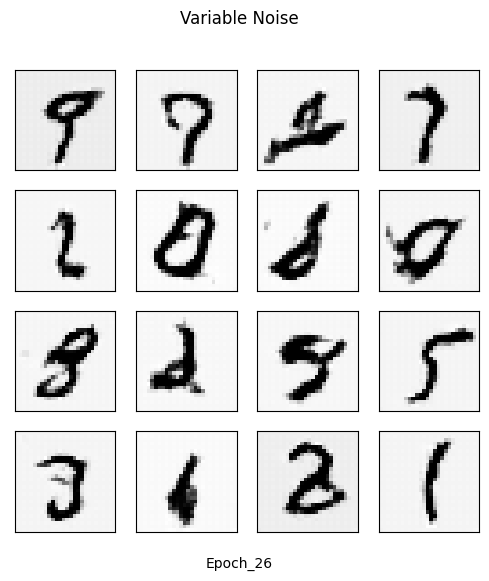

In [14]:
train(
    num_epochs=num_epochs,
    discriminator_net=discriminator_net,
    generator_net= generator_net,
    optimizerD=optimizerD,
    optimizerG=optimizerG,
    train_loader=train_loader,
    fake_label=fake_label,
    real_label=real_label,
    criterion=criterion,
    output_path=output_path,
    num_test_samples=num_test_samples,
    device=device,
    noise_vector=noise_vector
)

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

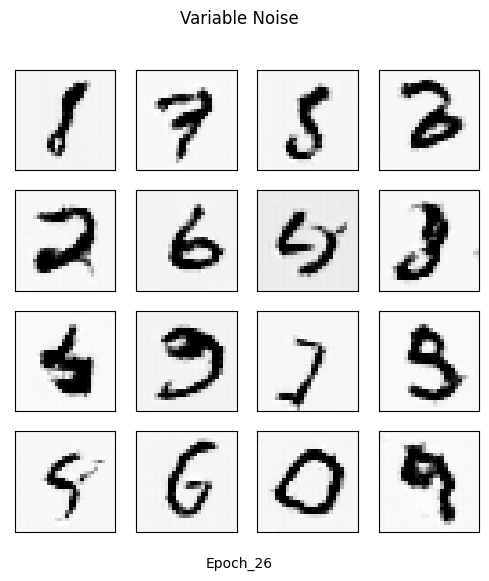

In [15]:
generator_net.eval()
plot_images(
        25,
        output_path,
        num_test_samples,
        generator_net,
        device,
    )
generator_net.train()